<a href="https://colab.research.google.com/github/noayarae/Machine_Learning_notes/blob/main/Copy_of_00_XGBoost_with_manual_tuned_parms_SB31_submit_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**
XGBoost model for temporal prediction of stream temperature in **sub-basin # 31** of the Dairy McKay watershed. This code involves data reading, data processing, training, testing, and validation of the model. 

Author: **Efrain Noa-Yarasca PhD**

# **I. XGBoost Regression model with Tunning**

In this page, the XGBoost model is trained and tested for stream temperatura prediction considering the sir-temperature (Ta), wind (Wind), solar radiation (SR), relative humisity (HR), the day in the year (DY), streamflow (Flow), precipitation (pp), and the shade factor (FS) as predictor variables. The daily stream temperature (Tw) is set as the only response variable.

Clean all variables

In [ ]:
### Reset variables
from IPython import get_ipython
get_ipython().magic('reset -sf')

### **1. Read data**
Data in format CSV is read using the "read_csv" function

In [ ]:
from pandas import read_csv
# Read DATA. 
data = read_csv('005_sb31_8v_no_norm_SF0_SFmax_2012_2017_for_train_test.csv', header=0, index_col=0)
#data = read_csv('005_sb59_8v_no_norm_SF0_SFmax.csv', header=0, index_col=0) 
#print (data.head())

### Select predictor and response variables
X = data.drop(['scenario', 'Tw'],axis=1) # For SB-31
#X = data.drop(['scenario', 'Tw_59'],axis=1) # For SB 59
y = data['Tw'] #y = data['Tw_59'] # 
print ("Data dimension (X), (y):", X.shape, y.shape)

### Split into train and test (Random split)
from sklearn.model_selection import train_test_split
# Test-size: 30%, Train-size: 70%
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=1)
print("Datasets dimension \n train_x, train_y, test_x, test_y: \n", 
      train_x.shape, test_x.shape, train_y.shape, test_y.shape)

Data dimension (X), (y): (6438, 8) (6438,)
Datasets dimension 
 train_x, train_y, test_x, test_y: 
 (4506, 8) (1932, 8) (4506,) (1932,)


### **2. Model definition and fit. Prediction and errors**


In [ ]:
from xgboost import XGBRegressor

### XGBoost model based on best parameters from mannual tuning
print ("computing ........")
model_best_parm = XGBRegressor(
    alpha = 0.001,# alias "reg_alpha"
    booster = 'gbtree',
    colsample_bytree = 0.9,
    learning_rate = 0.01,
    max_depth = 8,
    n_estimators = 1500,
    objective = 'reg:squarederror',
    subsample = 0.55,
    min_child_weight= 5, #1,
    gamma= 0.1, #0,
    seed=1
    )

### Fit the model and evaluation using train ans test
eval_set = [(train_x, train_y), (test_x, test_y)]
model_best_parm.fit(train_x, train_y,eval_metric=["rmse"], eval_set=eval_set,verbose=0)

### Prediction on train and test
pred_train = model_best_parm.predict(train_x) # prediction for 'Train' values
predict_test = model_best_parm.predict(test_x)

### RMSE and R2 on train and test using the model with best parameters
from sklearn.metrics import mean_squared_error, r2_score  ## use function score   RMSE

print("Train","RMSE: %.4f" % (mean_squared_error(train_y, model_best_parm.predict(train_x))**(1/2.0)))
print("Test", "RMSE: %.4f" % (mean_squared_error(test_y, model_best_parm.predict(test_x))**(1/2.0)))
print ()

print("Train","R2: %.4f" % (model_best_parm.score(train_x, train_y))) # R2
print("Test", "R2: %.4f" % (model_best_parm.score(test_x, test_y)))   # R2


computing ........
Train RMSE: 0.1730
Test RMSE: 0.4162

Train R2: 0.9983
Test R2: 0.9898


### 3. Learning curve

# of epochs: 1500


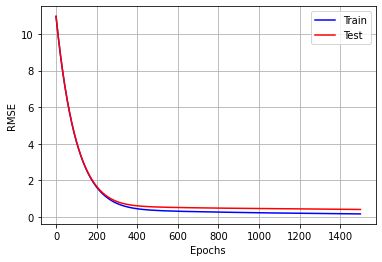

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
### Plot learning rate
import matplotlib.pyplot as plt
results = model_best_parm.evals_result() # Get rmse for validation 0 (train) & validatio 1 (test)

epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
print ("# of epochs:", epochs)

fig = plt.figure(figsize=(6, 4))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train', color='blue')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test', color='red')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.grid()
plt.show() #'''

from google.colab import files
fig.savefig('001_sb31_xgb_learning_curve.png', dpi=1024)
#files.download("001_sb31_xgb_learning_curve.png") 

### **4. Importance of variables**

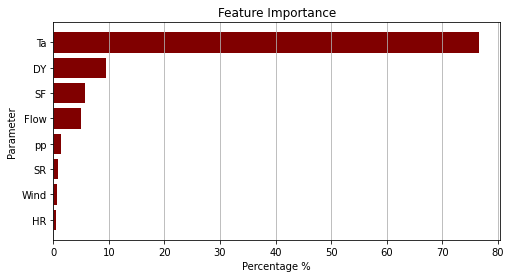

Importance in percentages: 
 [76.581985    9.473298    5.6023064   5.0402393   1.428185    0.7411132
  0.60113657  0.53174317]


In [ ]:
### Plot importance of parameters
import numpy as np
import matplotlib.pyplot as plt

f_importance = 100*model_best_parm.feature_importances_
sorted_idx = np.argsort(f_importance)
fig = plt.figure(figsize=(8, 4))
plt.barh(range(len(sorted_idx)), f_importance[sorted_idx], align='center',color ='maroon')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
plt.grid(axis="x")
plt.xlabel("Percentage %")
plt.ylabel("Parameter")
plt.show()

print ("Importance in percentages: \n",f_importance[sorted_idx][::-1]) # Reversing the array to show values

fig.savefig('002_sb31_xgb_feat_importance.png', dpi=1024)
#files.download("003_sb31_xgb_feat_importance.png") 

### **5. Repeated Cross Validation for the model w/best parameters**

Models to be tested:  ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'M10', 'M11']
Model M1    ........ Done !
RMSE: [1.436623541714937, 1.5014564888831046, 1.4629981780109975, 1.568033587377297, 1.5618222589659199, 1.428494497448655, 1.4608344537869984, 1.5360503339335247, 1.509444795447664, 1.5311157887979019, 1.5578241146035634, 1.5669655296330285, 1.4630566523200206, 1.4191096790810709, 1.4812430194752118, 1.5394634242041485, 1.4728388436680386, 1.4995911600433918, 1.522765328610795, 1.4929684865153352, 1.517811593223476, 1.4873275056575173, 1.5059122233817448, 1.5168623591837977, 1.4665069493334748, 1.5448725973522275, 1.4886791297447894, 1.5181725647957987, 1.4461391632102192, 1.5266229127027255, 1.4823149390002845, 1.5084286906481033, 1.513045481240868, 1.5506366703211314, 1.5210045319502588, 1.5438333426141768, 1.5528016841337167, 1.4565186694402998, 1.4958286333426727, 1.4263206282719556, 1.475435073067215, 1.46438411508719, 1.4937597861878662, 1.4486339324149569, 1.50

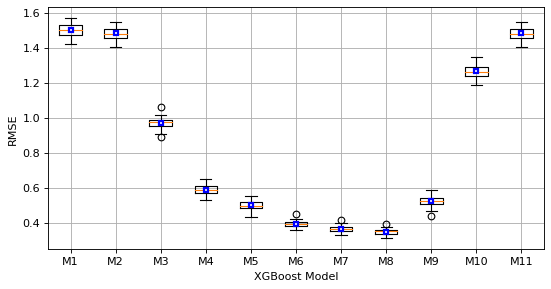

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

### Set of parameters for each model to be tested
set1 = X.drop(['HR','Wind','SR','pp','Flow','SF','DY'],axis=1)
set2 = X.drop(['HR','Wind','SR','pp','Flow','SF'],axis=1)
set3 = X.drop(['HR','Wind','SR','pp','Flow'],axis=1)
set4 = X.drop(['HR','Wind','SR','pp'],axis=1)
set5 = X.drop(['HR','Wind','SR'],axis=1)
set6 = X.drop(['HR','Wind'],axis=1)
set7 = X.drop(['HR'],axis=1)
set8 = X.drop([],axis=1)
set9 = X.drop(['Flow'],axis=1)
set10 = X.drop(['Wind','HR','SR','SF','Flow'],axis=1)
set11 = X.drop(['Wind','HR','pp','SR','SF','Flow'],axis=1)

sets = [set1,set2,set3,set4,set5,set6,set7,set8,set9,set10,set11]
#sets = [set1]
labels=[str(r) for r in sets]
sets_names = [f'M{i}' for i in range(1, 12)]
print("Models to be tested: ", sets_names)

### Cross validation through all models defined above
scores_all_models = []
ccc = 0
for set_var in sets:
  ccc+=1
  n_repts = 5 #  <---------- SET
  cvr = RepeatedKFold(n_splits = 10, n_repeats = n_repts, random_state=2)
  #modelt = mbp #XGBRegressor() #LogisticRegression()
  scores = cross_val_score(model_best_parm, set_var, y, scoring='neg_root_mean_squared_error', cv=cvr, n_jobs=-1)
  scores_p = [item * -1 for item in scores]
  print ("Model M"+str(ccc),"   ........ Done !") #print (scores_p)
  print ("RMSE:", scores_p)
  scores_all_models.append(scores_p)

### Get mean values of model's scores
from statistics import mean
#mean(scores_all_mods)
row_average = [sum(sub_list) / len(sub_list) for sub_list in scores_all_models]
print ("Mean values of RMSE for each tested model: \n",[round(n, 3) for n in row_average]) 
print ()

### Plot performance of all the models
fig = plt.figure(figsize=(8, 4), dpi=80)
plt.boxplot(scores_all_models, labels=sets_names, showmeans=1,
            meanprops={"marker":"s","markersize":"4","markerfacecolor":"white", 
                       "markeredgecolor":"blue", "markeredgewidth":"2"})

plt.xlabel("XGBoost Model")
plt.ylabel("RMSE")
plt.grid()
plt.show()

fig.savefig('003_sb31_xgb_boxplot_11models.png', dpi=1024)
#files.download("003_sb31_xgb_boxplot_11models.png")


In [ ]:
from google.colab import files
import pandas as pd
scores_df = pd.DataFrame(scores_all_models)
scores_df.to_csv('SB31_xgb_output_11models.csv')
#scores_all_models

### **6. Validation on new data that was not involved in training/testing**


In [ ]:
# Read new data for validation (one year data - the last available data) 
data_one_year = read_csv('005_sb31_8v_no_norm_SF0_SFmax_only_2018_for_validation.csv', header=0, index_col=0) 
#data_one_year = read_csv('005_sb59_8v_no_norm_SF0_SFmax_one_year_for_validation.csv', header=0, index_col=0)
data_one_year.head()

### Select Predictor (X_1yr) and response (X_1yr) variables 
X_1yr = data_one_year[['Ta','Wind','SR','HR','DY','Flow','pp','current_SF']]
#X_1yr = data_one_year[['Ta','DY','Flow','current_SF']]
X_1yr = X_1yr.rename({'current_SF': 'SF'}, axis=1) 

y_1yr = data_one_year['Tw_Hnow'] # y = data['Tw']
y_1yr = y_1yr.rename({'Tw_Hnow': 'Tw'}, axis=1)  # new method
print ("Data dimension (X), (y):", X_1yr.shape, y_1yr.shape)
#print (y_1yr)


Data dimension (X), (y): (365, 8) (365,)


Predictors: ['Ta' 'Wind' 'SR' 'HR' 'DY' 'Flow' 'pp' 'SF']    Response: [Tw]
X and y Dimension:  (365, 8) (365,)
RMSE: 0.74867
R2: 0.96565


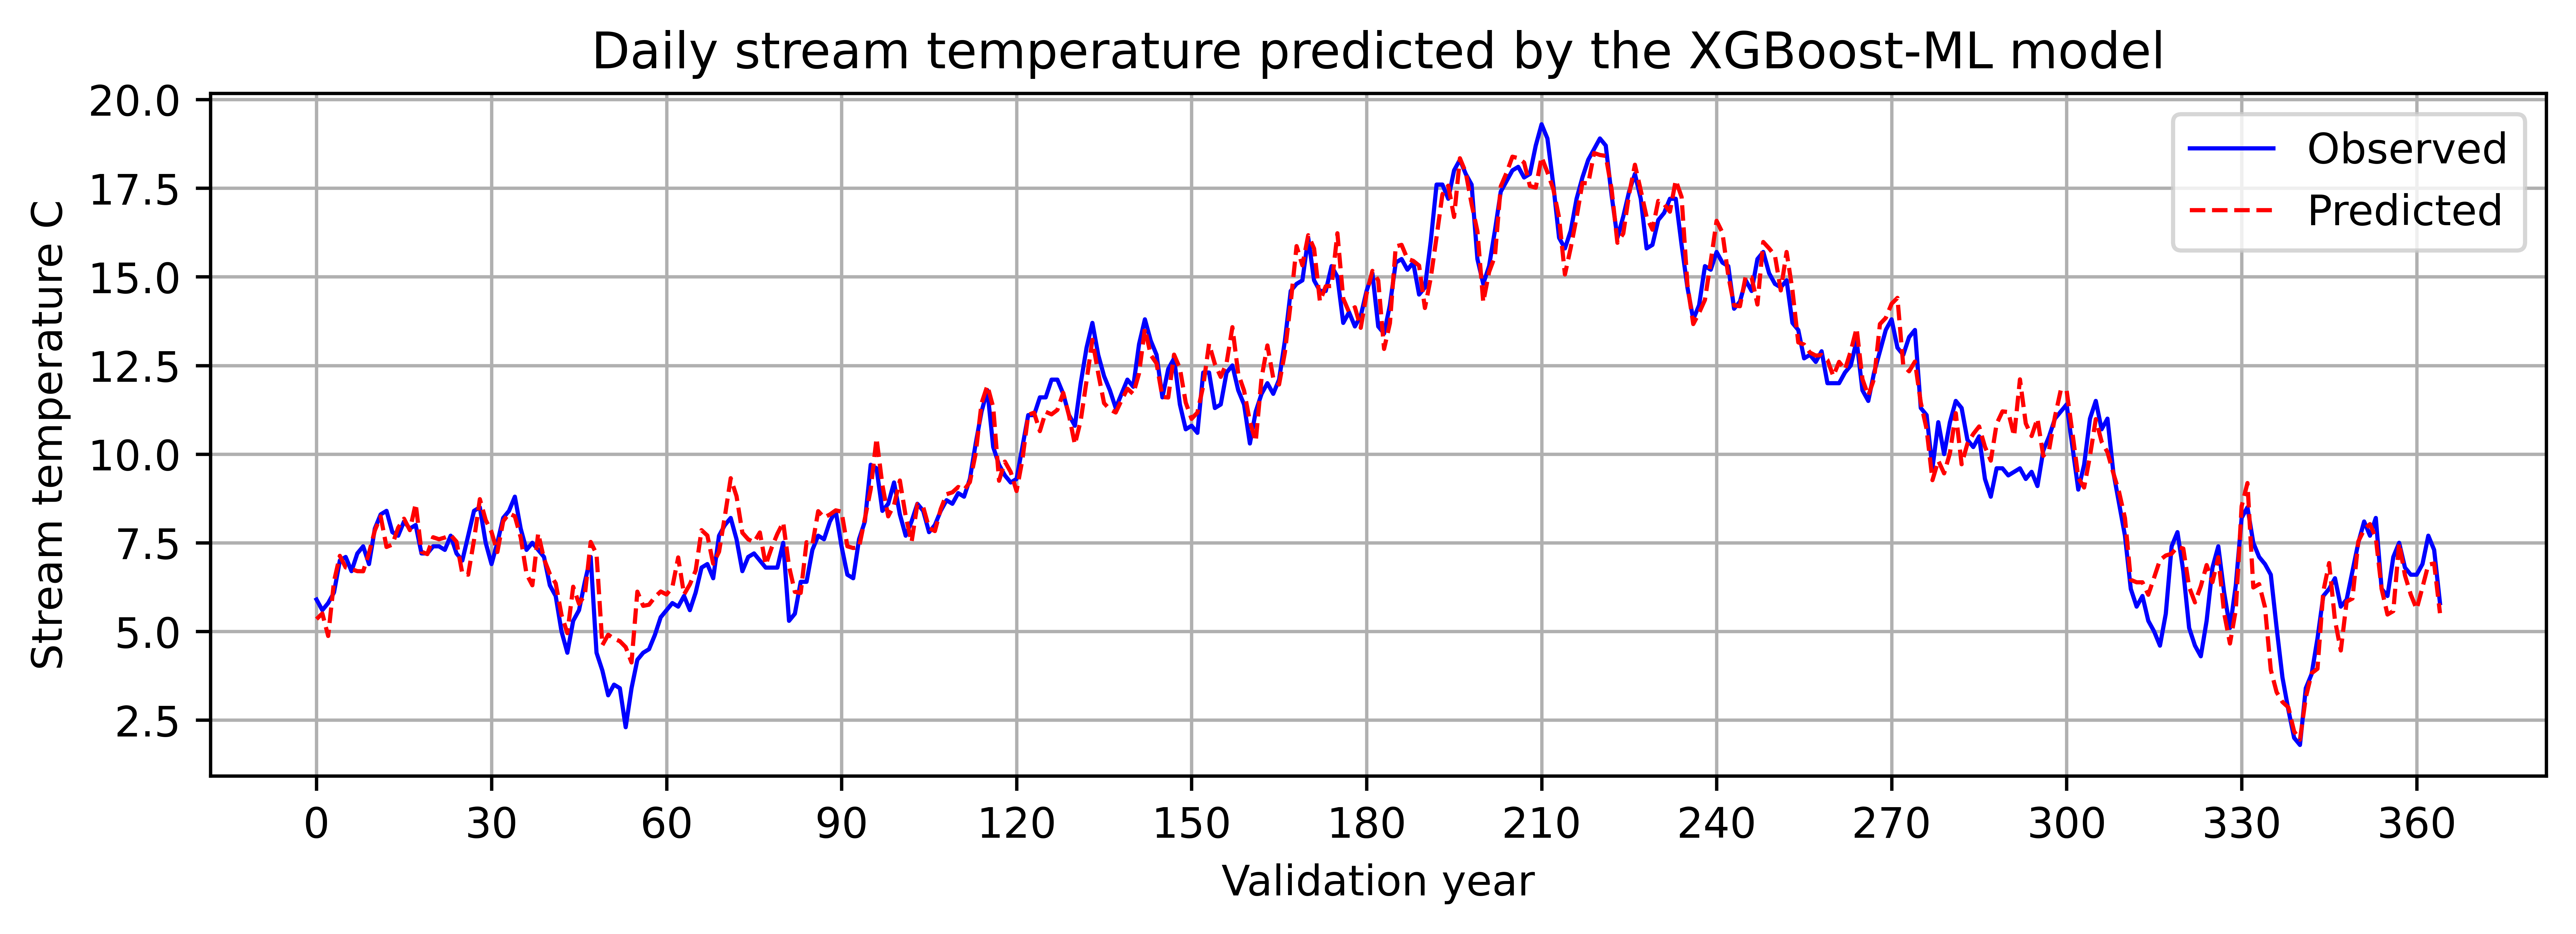

In [ ]:
### Prediction on new data (validation)
pred_1y = model_best_parm.predict(X_1yr)
#print (pred_1yr)
print ("Predictors:", X_1yr.columns.values, "   Response:",'[Tw]') # print predictor variable names
print ("X and y Dimension: ", X_1yr.shape, y_1yr.shape) # print dimension of variables

### RMSE and R2 on new data (validation)
from sklearn.metrics import mean_squared_error, r2_score  ## use function score   RMSE
print("RMSE: %.5f" % (mean_squared_error(y_1yr, pred_1y)**(1/2.0)))
print("R2: %.5f" % (model_best_parm.score(X_1yr,y_1yr))) # R2

### Plot Time Series of Observed and Predicted data (Validation)
### (One year of records not involved in model training/testing)
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
x_ax = range(len(y_1yr)) #range(len(test_y))

fig = plt.figure(figsize=(10, 3), dpi=1024)
#plt.scatter(x_ax, ty, s=5, color="blue", label="Observed")
plt.plot(x_ax, y_1yr, lw=1.0, color="blue", label="Observed")
plt.plot(x_ax, pred_1y, lw=1.0, color="red", label="Predicted", linestyle='--')

plt.title("Daily stream temperature predicted by the XGBoost-ML model")
plt.xlabel("Validation year")
plt.ylabel("Stream temperature C")
plt.legend()
#plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xticks(np.arange(0, 365+1, 30.0))
plt.grid()
plt.show()

fig.savefig('004_sb31_xgb_time_series_plot.png', dpi=1024)
#files.download("004_sb31_xgb_time_series_plot.png")

Observed Stream-temperature
[5.9, 5.6, 5.8, 6.1, 7.0, 7.1, 6.7, 7.2, 7.4, 6.9, 7.9, 8.3, 8.4, 7.8, 7.7, 8.1, 7.9, 8.0, 7.2, 7.2, 7.4, 7.4, 7.3, 7.7, 7.2, 7.0, 7.7, 8.4, 8.5, 7.5, 6.9, 7.5, 8.2, 8.4, 8.8, 7.9, 7.3, 7.5, 7.3, 7.1, 6.3, 6.0, 5.0, 4.4, 5.3, 5.6, 6.4, 7.1, 4.4, 3.9, 3.2, 3.5, 3.4, 2.3, 3.4, 4.2, 4.4, 4.5, 4.9, 5.4, 5.6, 5.8, 5.7, 6.0, 5.6, 6.1, 6.8, 6.9, 6.5, 7.7, 8.0, 8.2, 7.6, 6.7, 7.1, 7.2, 7.0, 6.8, 6.8, 6.8, 7.5, 5.3, 5.5, 6.4, 6.4, 7.3, 7.7, 7.6, 8.1, 8.4, 7.4, 6.6, 6.5, 7.6, 8.1, 9.7, 9.6, 8.4, 8.6, 9.2, 8.3, 7.7, 8.1, 8.6, 8.4, 7.8, 8.0, 8.4, 8.7, 8.6, 8.9, 8.8, 9.3, 10.3, 11.2, 11.8, 10.2, 9.7, 9.4, 9.2, 9.3, 10.2, 11.1, 11.1, 11.6, 11.6, 12.1, 12.1, 11.7, 11.1, 10.8, 12.0, 13.0, 13.7, 12.8, 12.2, 11.8, 11.3, 11.7, 12.1, 11.9, 13.1, 13.8, 13.2, 12.8, 11.6, 12.4, 12.7, 11.4, 10.7, 10.8, 10.6, 12.3, 12.3, 11.3, 11.4, 12.3, 12.5, 11.8, 11.4, 10.3, 11.2, 11.7, 12.0, 11.7, 12.1, 13.2, 14.6, 14.8, 14.9, 16.1, 14.9, 14.6, 14.6, 15.3, 15.0, 13.7, 14.0, 13.6, 13.9, 14.6, 15

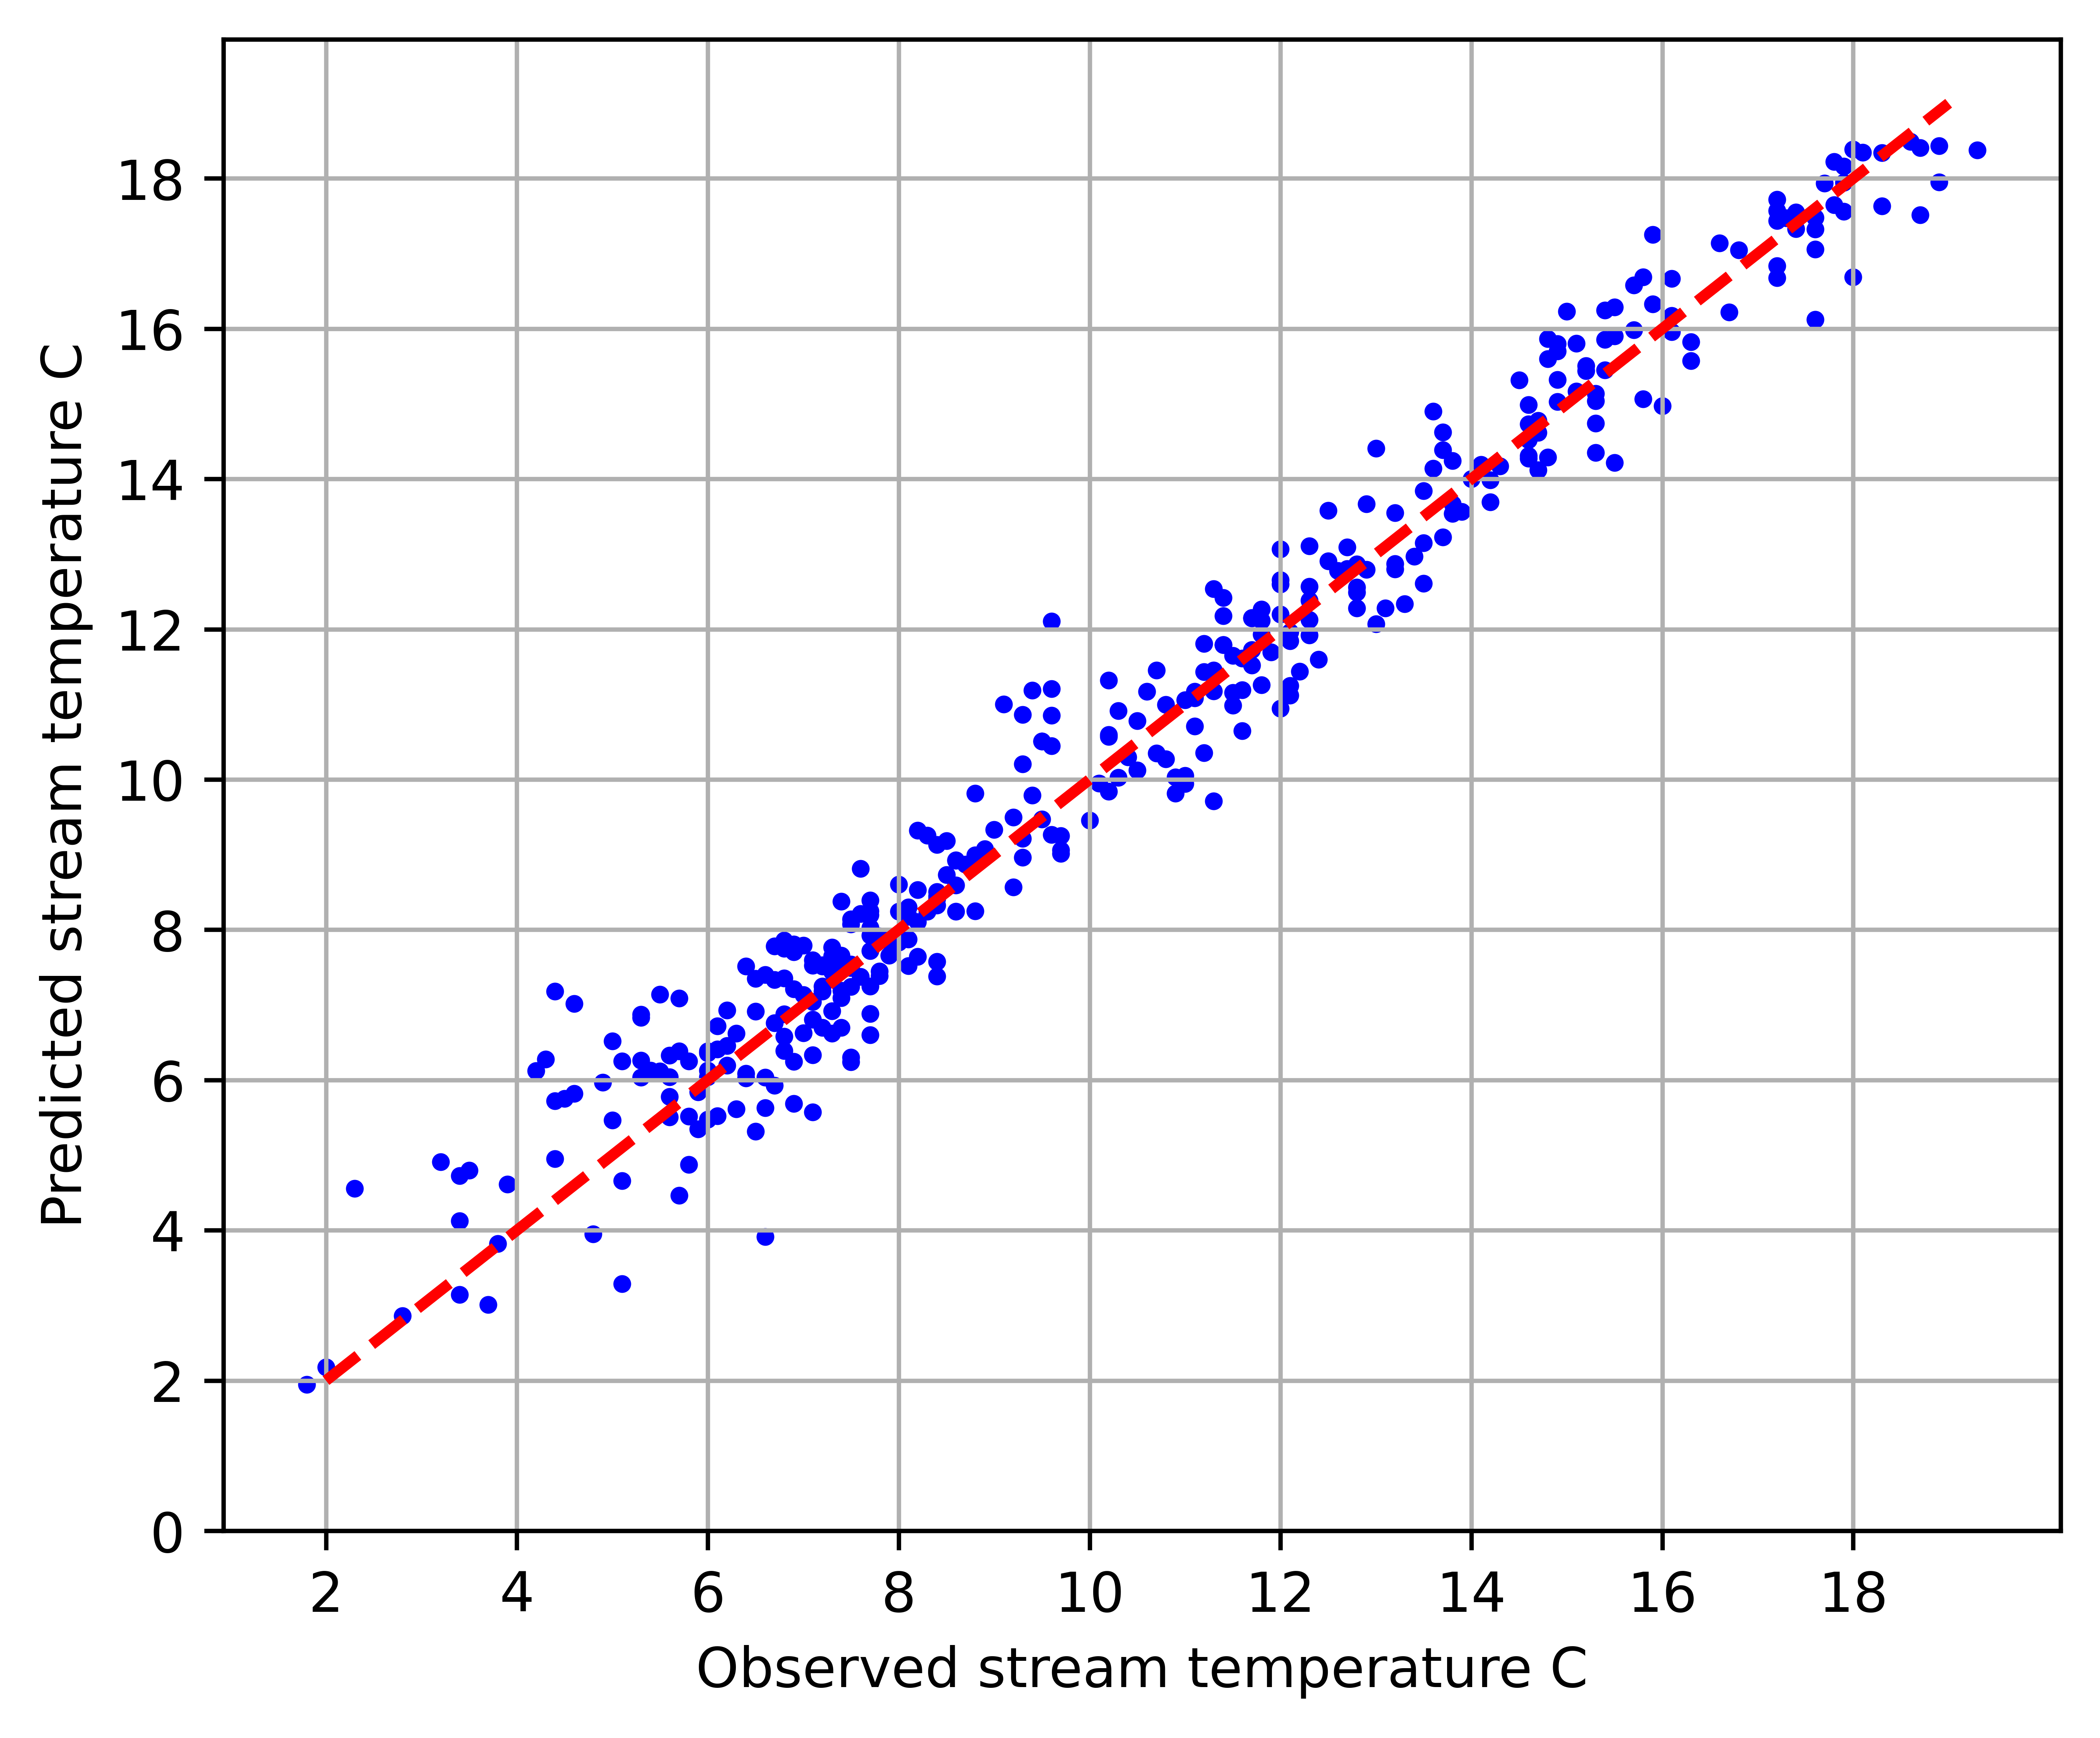

In [ ]:
### Plot scater plot Observed vs Predicted
print ("Observed Stream-temperature")
print (y_1yr.tolist()) # 
print ("Predicted Stream-temperature")
print ([round(n, 2) for n in pred_1y.tolist()])
avg_obs = sum(y_1yr.tolist())/len(y_1yr.tolist())
avg_pred = sum(pred_1y.tolist())/len(pred_1y.tolist())

print ("Avge-Obs-str-temp:", round(avg_obs, 3),"       Avge-Pred-str-temp:", round(avg_pred, 3))
print ("done....")

fig = plt.figure(figsize=(6, 5), dpi=1024)
plt.scatter(y_1yr, pred_1y, s=5, color="blue", label="Observed")
plt.plot([2, 19], [2, 19],  color='red', linestyle='--', linewidth=2)
plt.xticks(np.arange(2, 18+1, 2))
plt.yticks(np.arange(0, 18+1, 2))
plt.xlabel("Observed stream temperature C")
plt.ylabel("Predicted stream temperature C")
plt.grid()
plt.show()

fig.savefig('005_sb31_xgb_obs_vs_pred.png', dpi=1024)
#files.download("005_sb31_xgb_obs_vs_pred.png")